<a href="https://colab.research.google.com/github/AldhiPrambudi/BMKG_1/blob/RindangMuharzaViawan/Denpasar_Seasons_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1990-2020_day.txt')
df.head()

,dt_iso,temp_mean,temp_min_min,temp_max_max,pressure_mean,humidity_mean,wind_speed_mean,wind_deg_mean,clouds_all_mean,rain_1d
0,1990-01-01,26.333750,25.03,27.40,1009.333333,85.416667,1.477083,194.291667,91.541667,9.40
1,1990-01-02,25.559583,24.92,26.55,1009.666667,87.541667,2.096667,247.458333,99.958333,36.71
2,1990-01-03,26.956667,26.09,27.52,1008.583333,82.250000,2.122083,271.125000,96.000000,5.02
3,1990-01-04,26.638750,25.91,27.15,1007.958333,84.541667,2.652500,202.458333,98.541667,10.54
4,1990-01-05,27.940417,27.40,28.83,1007.916667,78.708333,2.905000,131.458333,99.708333,0.71


In [3]:
df.shape

(10964, 10)

In [4]:
df.describe()

,temp_mean,temp_min_min,temp_max_max,pressure_mean,humidity_mean,wind_speed_mean,wind_deg_mean,clouds_all_mean,rain_1d
count,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000
mean,27.273347,24.848543,30.145240,1010.043557,80.814358,3.615097,157.916497,38.428085,4.545826
std,1.069445,1.391260,1.551929,1.995368,4.300660,1.394986,63.101959,14.729778,12.830629
min,22.401250,2.000000,23.200000,1001.129167,61.958333,0.998333,48.000000,6.083333,0.000000
25%,26.510208,24.000000,29.000000,1008.719792,78.125000,2.560729,111.291667,28.333333,0.000000
50%,27.337500,25.000000,30.000000,1010.125000,80.875000,3.402708,124.833333,35.000000,0.180000
75%,28.070729,25.800000,31.000000,1011.483333,83.666667,4.399271,207.666667,44.541667,2.310000
max,31.339167,28.800000,39.800000,1017.037500,98.000000,12.765833,321.250000,100.000000,221.000000


In [5]:
df.loc[(df['temp_min_min'] < 22.4), 'temp_min_min'] = 22.4

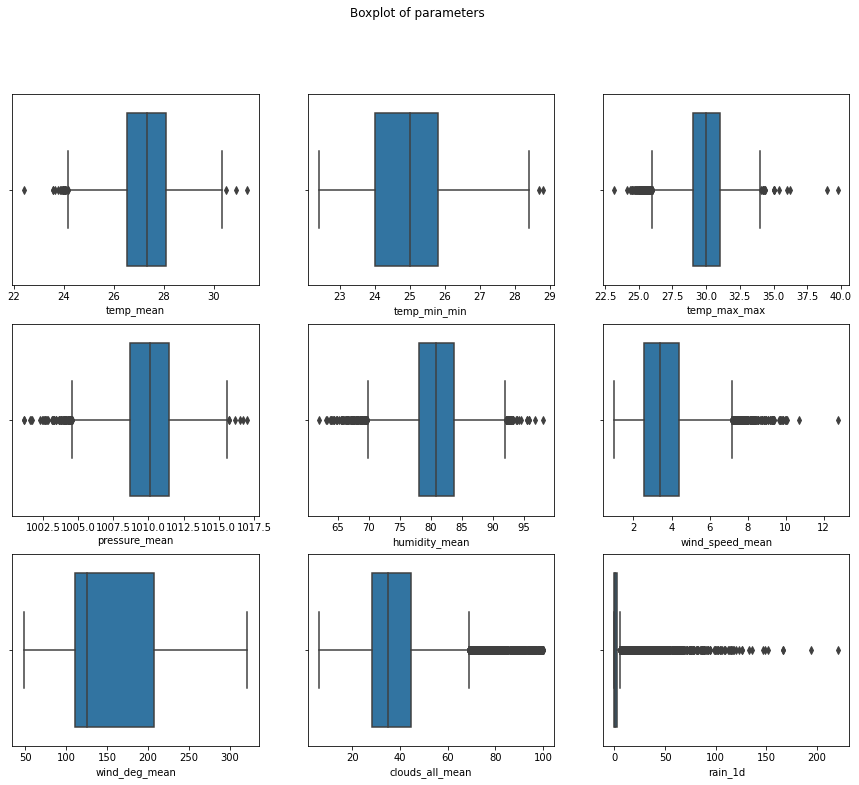

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Boxplot of parameters')
i, j = 0, 0
for c in df:
    if c != 'dt_iso':
        sns.boxplot(ax=axes[i, j], x=df[c])

        j = j + 1
        if j >= 3:
            j = 0
            i = i + 1

In [7]:
df_train = df[(df['dt_iso'] <= '2018-12-31')]
df_test = df[(df['dt_iso'] >= '2019-01-01') & (df['dt_iso'] <= '2019-12-31')]

In [8]:
df = df.set_index('dt_iso')
df_train = df_train.set_index('dt_iso')
df_test = df_test.set_index('dt_iso')

In [9]:
sc = MinMaxScaler(feature_range = (0, 1))
norm_df = sc.fit_transform(df_train)
norm_df

array([[0.43997949, 0.4109375 , 0.25301205, ..., 0.53537664, 0.90993789,
        0.04253394],
       [0.35336348, 0.39375   , 0.20180723, ..., 0.72994815, 0.99955634,
        0.1661086 ],
       [0.50967321, 0.5765625 , 0.26024096, ..., 0.81655993, 0.95740905,
        0.02271493],
       ...,
       [0.6979628 , 0.625     , 0.48192771, ..., 0.83074108, 0.26796806,
        0.01900452],
       [0.68220596, 0.5625    , 0.48192771, ..., 0.81091796, 0.17258208,
        0.        ],
       [0.70807888, 0.5625    , 0.53012048, ..., 0.41445563, 0.42502218,
        0.01040724]])

In [20]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [21]:
past_history = 730
future_target = 365
n_feature = 6
STEP = 1 # 6
TRAIN_SPLIT = 9496 # 2016
x_train_multi, y_train_multi = multivariate_data(norm_df, norm_df[:, 5], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(norm_df, norm_df[:, 5],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [22]:
model = keras.models.Sequential([
  keras.layers.Bidirectional(keras.layers.GRU(units=32, return_sequences = True, input_shape=(past_history, n_feature))),
  keras.layers.Dropout(0.2),
  keras.layers.Bidirectional(keras.layers.GRU(units=32)),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(units = future_target)
])

In [23]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [25]:
epoch = 10
batch_size = 128
model.fit(x_train_multi, y_train_multi, validation_data=(x_val_multi, y_val_multi), epochs = epoch, batch_size = batch_size)

Epoch 1/10
69/69 [==============================] - 130s 2s/step - loss: 0.0225 - val_loss: 0.0190
Epoch 2/10
69/69 [==============================] - 118s 2s/step - loss: 0.0138 - val_loss: 0.0190
Epoch 3/10
69/69 [==============================] - 119s 2s/step - loss: 0.0132 - val_loss: 0.0190
Epoch 4/10
69/69 [==============================] - 117s 2s/step - loss: 0.0128 - val_loss: 0.0191
Epoch 5/10
69/69 [==============================] - 117s 2s/step - loss: 0.0126 - val_loss: 0.0193
Epoch 6/10
69/69 [==============================] - 115s 2s/step - loss: 0.0124 - val_loss: 0.0190
Epoch 7/10
69/69 [==============================] - 117s 2s/step - loss: 0.0123 - val_loss: 0.0196
Epoch 8/10
69/69 [==============================] - 117s 2s/step - loss: 0.0121 - val_loss: 0.0193
Epoch 9/10
69/69 [==============================] - 118s 2s/step - loss: 0.0119 - val_loss: 0.0192
Epoch 10/10
69/69 [==============================] - 115s 2s/step - loss: 0.0117 - val_loss: 0.0185


In [26]:
model.save('/content/drive/MyDrive/Colab Notebooks/modelLSTM.h5')

In [30]:
X_predict = norm_df[-past_history:].reshape((-1, past_history, n_feature))

ValueError: ignored